# Setup ice box
- get ice config with https://github.com/vitroid/GenIce
- equilibrate with anisotropic barostat (optional)
- equilibrate with fixed volume
- run MD at fixed volume

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

In [3]:
import openmm, openmm.app
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [4]:
from rigid_flows.systems.watermodel import WaterModel, plot_energy

## generate ice configuration and setup water model
see https://github.com/vitroid/GenIce

In [5]:
#some options

temp = 100
# water_type = 'tip4pew'
water_type = 'tip4pice'
ice_type = 'XI'
rep = 3*[1]

nonbondedCutoff = 1
rigidWater = True
external_field = None

anisotropic_equilibration = False

# !genice2 -h  #see available ice_types

+++ WARNING: `nonbondedCutoff` too large, changed to 0.36678 +++


n_waters: 16
orthorombic: True
nonbondedCutoff: 0.36678 (1.1582 [sigmaLJ])


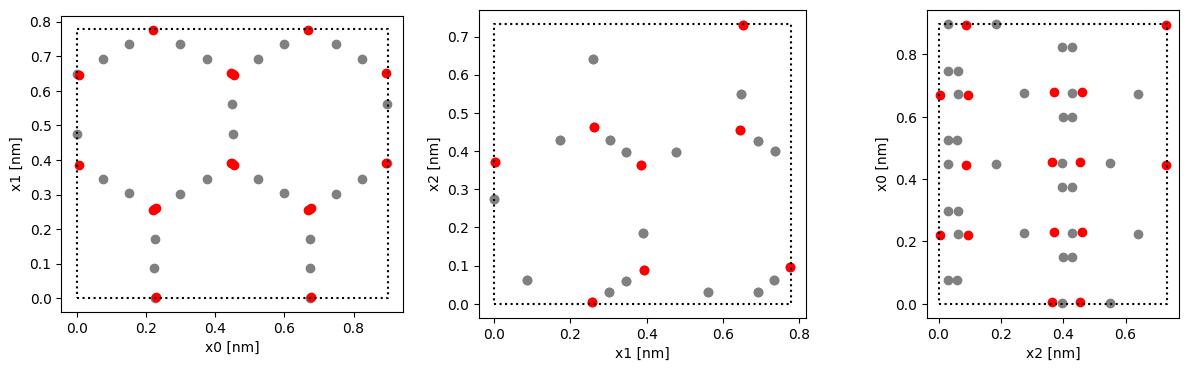

NGLWidget()

In [6]:
#setup the model
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule
from tempfile import NamedTemporaryFile

gro = GenIce(Lattice(ice_type), rep=rep).generate_ice(Format('gromacs'), water=Molecule(water_type[:5]))
tmp = NamedTemporaryFile()
with open(tmp.name, 'w') as f:
    f.write(gro)
config = openmm.app.GromacsGroFile(tmp.name)

pos = np.array(config.getPositions().value_in_unit(unit.nanometer))
box = np.array(config.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
model = WaterModel(
    positions=pos,
    box=box,
    water_type=water_type,
    nonbondedCutoff=nonbondedCutoff,
    rigidWater=rigidWater,
    external_field=external_field,
)

print('n_waters:', model.n_waters)
print('orthorombic:', model.is_box_orthorombic)
print(f'nonbondedCutoff: {model.nonbondedCutoff} ({model.nonbondedCutoff/model.sigma_O:g} [sigmaLJ])') #3.16 is common, 2.5 is ok, below 1.14 is very bad

if model.is_box_orthorombic:
    toPBC = True
else:
    toPBC = False
model.plot_2Dview(toPBC=toPBC)
model.get_view()

In [7]:
# pos = model.positions + np.diag(model.box) / 8 / rep[0] #more centered view
# model.plot_2Dview(pos)
# view = model.get_view(pos)
# view

In [8]:
# view.download_image(filename=f'ice{ice_type}-N{model.n_waters}.png', trim=True, transparent=True)

In [9]:
model.system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7fb5c126bab0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7fb590ad9290> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7fb590ad9380> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7fb590ad9320> >]

In [10]:
# raise SystemError('Safety break')

## anisotropic equilibration

In [11]:
%%time 
#equilibrate
if anisotropic_equilibration:
    model.set_barostat('aniso', pressure=1*unit.megapascal)
    print('barostat:', model.barostat)

    pace = 500
    n_iter = 10_000   
    simulation = model.setup_simulation(temp, minimizeEnergy=True)
    
    MDene = np.full(n_iter, np.nan)
    MDpos = np.full((n_iter, *model.positions.shape), np.nan)
    if model.barostat is None:
        MDbox = np.resize(model.box, (1,3,3))
    else:
        MDbox = np.full((n_iter, 3, 3), np.nan)

    for n in trange(n_iter):
        simulation.step(pace)
        MDene[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
        MDpos[n] = simulation.context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True).value_in_unit(unit.nanometers)
        if model.barostat is not None:
            MDbox[n] = simulation.context.getState().getPeriodicBoxVectors(asNumpy=True).value_in_unit(unit.nanometers)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [12]:
#visualize
if anisotropic_equilibration:
    for i in range(3):
        plt.plot(MDbox[:,i,i], '.')
        print(box[i,i], MDbox[:,i,i].mean(), MDbox[-len(MDbox)//2:,i,i].mean())
        plt.axhline(MDbox[-len(MDbox)//2:,i,i].mean(), c='k', ls='--')
        plt.axhline(model.box[i,i], c='k', ls=':')
        # plt.ylim(0,None)
    plt.show()
    
    plot_energy(MDene)
    plot_2Dview(MDpos, MDbox)
    # model.get_view(MDpos, MDbox)

In [13]:
#update the model
if anisotropic_equilibration:
    model.positions = MDpos[-1]
    model.box = MDbox[-len(MDbox)//2:].mean(axis=0)
    model.system.getForces()

## fixed volume equilibration

In [14]:
%%time
#Equilibrate

model.set_barostat = None
print('barostat:', model.barostat)

pace = 500
n_iter = 10_000
simulation = model.setup_simulation(temp, minimizeEnergy=(not anisotropic_equilibration))

MDene = np.full(n_iter, np.nan)
MDpos = np.full((n_iter, *model.positions.shape), np.nan)
if model.barostat is None:
    MDbox = np.resize(model.box, (1,3,3))
else:
    MDbox = np.full((n_iter, 3, 3), np.nan)

for n in trange(n_iter):
    simulation.step(pace)
    MDene[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    MDpos[n] = simulation.context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True).value_in_unit(unit.nanometers)
    if model.barostat is not None:
        MDbox[n] = simulation.context.getState().getPeriodicBoxVectors(asNumpy=True).value_in_unit(unit.nanometers)

barostat: None
old energy: -1134.7117597173674
new energy: -1102.1551190923674


100%|██████████| 10000/10000 [09:09<00:00, 18.20it/s]

CPU times: user 9min 8s, sys: 4.08 s, total: 9min 12s
Wall time: 9min 9s


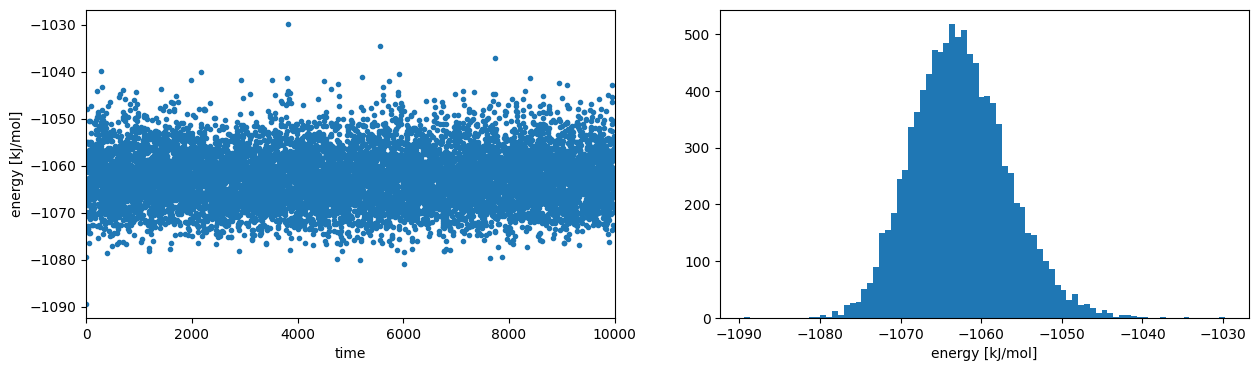

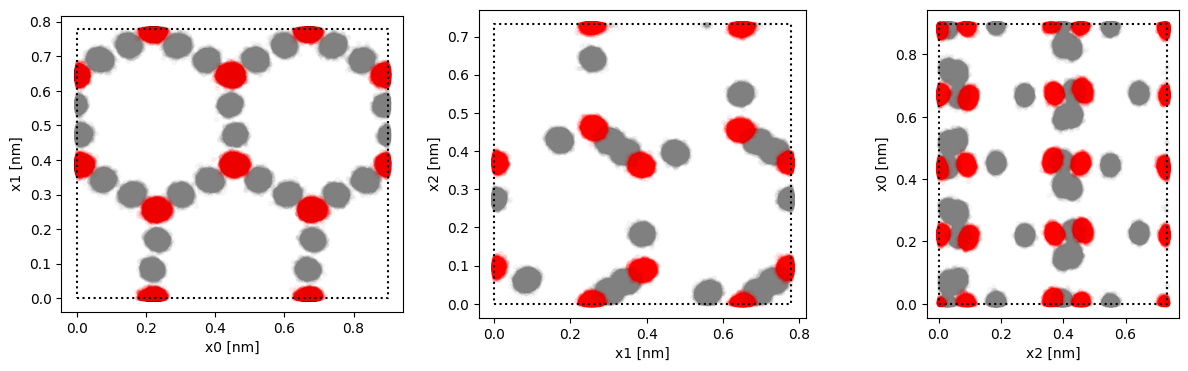

In [15]:
#visualize
plot_energy(MDene)
model.plot_2Dview(MDpos, MDbox, toPBC=toPBC)
# model.get_view(MDpos, MDbox)

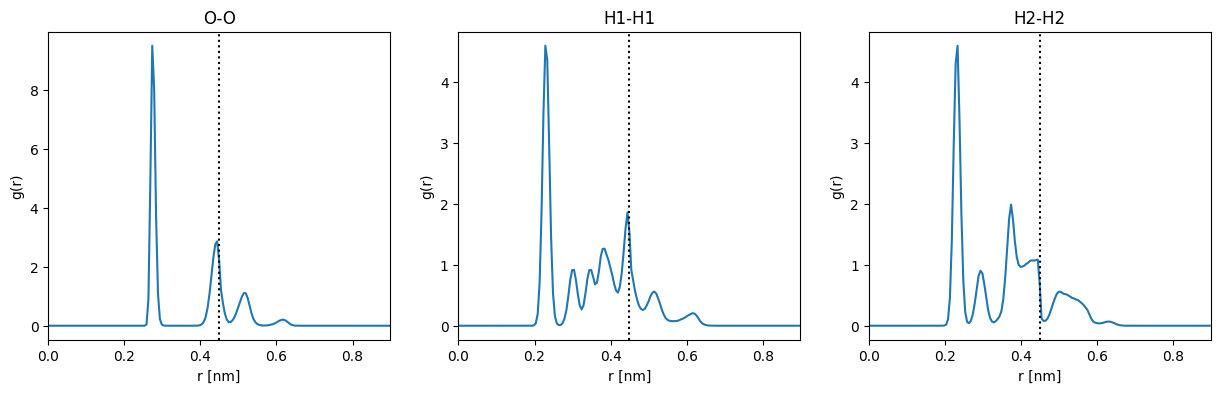

In [16]:
r_range = [0, model.box.max()]

names = ['O', 'H1', 'H2']
n = 1
plt.figure(figsize=(5*len(names), 4))
for a in names:
    plt.subplot(1, len(names), n)
    
    plt.title(f'{a}-{a}')
    model.plot_rdf(MDpos, r_range=r_range, selection=f'name == {a}')
    plt.axvline(model.box.max()/2, ls=':', c='k')
    n += 1
    
plt.show()

In [17]:
#update model
model.positions = MDpos[-1]
model.box = MDbox[-1]
model.system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7fb6142568e0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7fb5901e67f0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7fb5901e6820> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7fb5901e6850> >]

In [18]:
# raise SystemError('Safety break')

## run MD storing model and trajectory

In [19]:
%%time
#production run

print('barostat:', model.barostat)

pace = 500
n_iter = 100_000
# simulation = model.setup_simulation(temp)

MDene = np.full(n_iter, np.nan)
MDpos = np.full((n_iter, *model.positions.shape), np.nan)
if model.barostat is None:
    MDbox = np.resize(model.box, (1,3,3))
else:
    MDbox = np.full((n_iter, 3, 3), np.nan)

for n in trange(n_iter):
    simulation.step(pace)
    MDene[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    MDpos[n] = simulation.context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True).value_in_unit(unit.nanometers)
    if model.barostat is not None:
        MDbox[n] = simulation.context.getState().getPeriodicBoxVectors(asNumpy=True).value_in_unit(unit.nanometers)

barostat: None


100%|██████████| 100000/100000 [1:31:33<00:00, 18.20it/s]

CPU times: user 1h 32min, sys: 43.9 s, total: 1h 32min 44s
Wall time: 1h 31min 33s


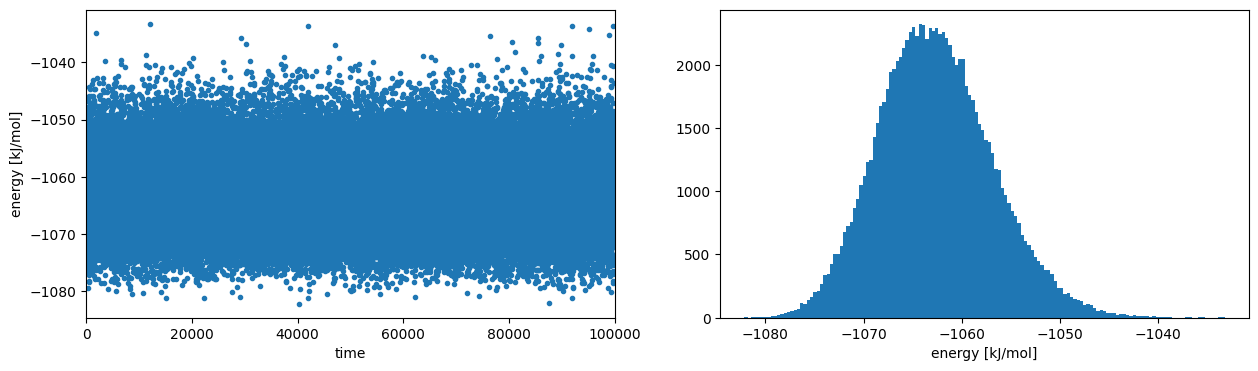

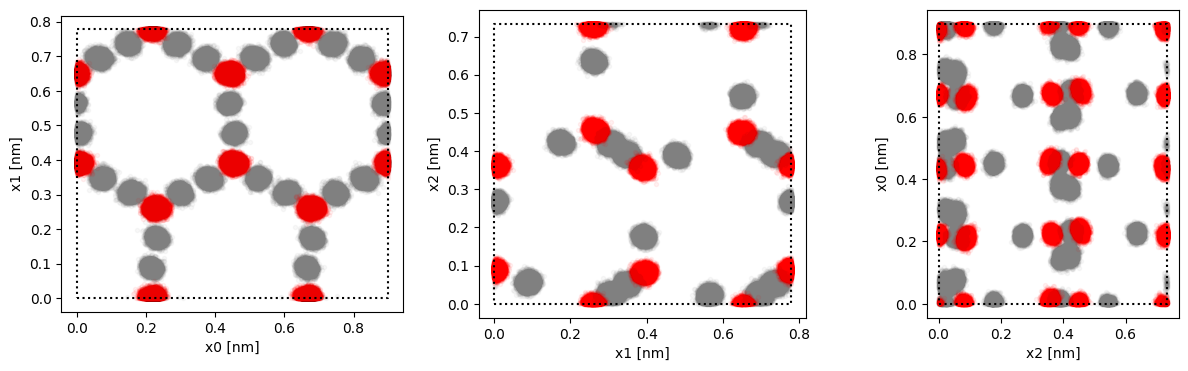

In [20]:
#visualize
plot_energy(MDene)
model.plot_2Dview(MDpos[::10], MDbox[::10], toPBC=toPBC)
# model.get_view(MDpos, MDbox)

In [21]:
# raise SystemError('Safety break')

In [22]:
#save trajectory
#NB: positions can be out of PBC, to avoid breaking molecules
info = f'ice{ice_type}_T{temp}_N{model.n_waters}'
if model.water_type != 'tip4pew':
    info = f'{model.water_type}_{info}'
if not rigidWater:
    info = f'flex_{info}'
filename_model = f'model-{info}.json'
# !bck.meup.sh -v {filename_model}
model.save_to_json(filename_model)

filename_MDtraj = f'MDtraj-{info}.npz'
# !bck.meup.sh -v {filename_MDtraj}
np.savez(filename_MDtraj, pos=MDpos, box=MDbox, ene=MDene)

#move to scratch
scratch_folder = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
!bck.meup.sh -v {scratch_folder}{filename_model} {scratch_folder}{filename_MDtraj}
!mv {filename_model} {filename_MDtraj} {scratch_folder}

--> bck.meup.sh:  file "/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-tip4pice_iceXI_T100_N16.json" not found
--> bck.meup.sh:  file "/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-tip4pice_iceXI_T100_N16.npz" not found


In [ ]:
# #load model from file
# filename = f'model-{info}.json'
# new_model = WaterModel.load_from_json(filename)